# Описание проекта

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

# Загрузка библиотек и настройка рабочей среды

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
# import time

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import root_mean_squared_error

from tqdm import tqdm

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

from tensorflow import keras

# Load model directly
import tensorflow as tf
import transformers
# from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel
# from transformers import BertTokenizer, TFBertModel, TFBertForPreTraining


from IPython.display import clear_output

# убрать предупреждения
import warnings
warnings.filterwarnings('ignore')

# настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

# необходимо для показа всех столбцов.
pd.options.display.max_columns = None

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

tf.config.run_functions_eagerly(True)

clear_output()

In [ ]:
# Константы
EMBEDDING_SIZE = 768  # Фиксированный размер для bert-base-uncased
MAX_LENGTH = 128      # Максимальная длина текста для токенизации


seed = 404

# Определение классов и функций

In [ ]:
def check_df(df, name=None):
    print(f"----Датасет {name}")
    print(df.info())
    print(f"----Размер: ",df.shape)
    print(f'----Полные дубликаты:\n', df.duplicated().sum())
    print(f'----Наличие пропусков:\n', df.isna().sum())
    print(f'----Head of dataset:\n')
    display(df.head())

In [ ]:
def get_wordnet_mapping_pos(line):
    """Map POS tag to first character wordnet_lemmatizer() accepts"""
    tag_array = []
    for word_tag in nltk.pos_tag(line.split(" ")):
        tag = word_tag[1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        tag_array.append((word_tag[0], tag_dict.get(tag, wordnet.NOUN)))
    return tag_array

In [ ]:
def filter_warnings(tokens):
    '''Define good query per token list'''
    return False if list(filter(lambda x: x in child_related_words, tokens)) else True

In [ ]:
def check_law(query):
    '''Проверка запроса на соответсвие закону. True если соответсвует'''
    lemmatizer = WordNetLemmatizer()
    lem_query = [lemmatizer.lemmatize(word=w, pos=t) for w, t in get_wordnet_mapping_pos(query)]
    return filter_warnings(lem_query)

In [ ]:
# deepseek created

def get_bert_embedding(text: str):
    """Получение эмбеддинга для одного текста с фиксированной размерностью"""
    try:
        inputs = tokenizer(
            text,
            return_tensors='tf',
            padding='max_length',
            truncation=True,
            max_length=MAX_LENGTH
        )
        outputs = bert_model(inputs)
        # Берем [CLS] токен и гарантируем размер EMBEDDING_SIZE
        embedding = outputs.last_hidden_state[0, 0, :].numpy()
        return embedding[:EMBEDDING_SIZE]  # Обрезаем на случай если размер больше
    except Exception as e:
        print(f"Ошибка обработки текста: '{text[:50]}...'. Возвращаю нулевой вектор. Ошибка: {e}")
        return np.zeros(EMBEDDING_SIZE)

def process_batch(texts: pd.Series, batch_size: int = 32):
    """Обработка батча текстов с гарантией одинаковой размерности эмбеддингов"""
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts.iloc[i:i+batch_size]
        batch_embeddings = [get_bert_embedding(text) for text in batch]

        # Проверка размерности
        for emb in batch_embeddings:
            if len(emb) != EMBEDDING_SIZE:
                emb = np.pad(emb, (0, max(0, EMBEDDING_SIZE - len(emb))))[:EMBEDDING_SIZE]

        embeddings.extend(batch_embeddings)

    return embeddings

In [ ]:
def  submit_query(query_sample):
    '''Получение по запросу топ 3 предсказанных изображения'''
    relevant_img = query_sample['relevant_img']
    query_text = query_sample['query_text']
    print(f'Полученный запрос:\n {query_text}\n')

    if not check_law(query_text):
        print ('This image is unavailable in your country in compliance with local laws'.upper())
        return None

    print(f'Релевантное изображение')

    # Загрузка изображения
    img = image.load_img(fr'test_images/{relevant_img}', target_size=(224, 224))
    # Конвертация в numpy array
    img_array = image.img_to_array(img) / 255.0

    # Отображение
    pl = plt.imshow(img_array)
    pl = plt.axis('off')
    plt.show()

    _ = pd.DataFrame()
    _['image'] = test_img_df.img
    _['vector'] = test_img_df.img_vect.agg(lambda x: np.concatenate([query_sample['query_vector'], x]))
    _['target'] = net_model.predict(np.vstack(_['vector'].values))

    print(f'Самая высокая оценка совместимости по имеющимся изображениям: {_["target"].max()}')


    submit_img = _.sort_values(by='target', ascending=False).reset_index(drop=True).head(3).image.tolist()

    print('Три лучших изображения по запросу')

    for img in submit_img:

        # Загрузка изображения
        img = image.load_img(fr'test_images/{img}', target_size=(224, 224))
        # Конвертация в numpy array
        img_array = image.img_to_array(img) / 255.0

        # Отображение
        pl = plt.imshow(img_array)
        pl = plt.axis('off')
        plt.show()


# Предобработка данных

In [ ]:
DATA_PATH = r""

In [ ]:
try:
    train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))
    crowd_df = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t', header=None, names=['image', 'query_id', 'part_of_true', 'count_true', 'count_false'])
    expert_df = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t', header=None, names=['image', 'query_id', 'exp_1', 'exp_2', 'exp_3'])
    test_q = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), sep='|', index_col=[0])
    test_img = pd.read_csv(os.path.join(DATA_PATH, 'test_images.csv'))
except Exception:
    raise FileNotFoundError('Check path for files')

In [ ]:
check_df(train_df, 'train_df')

----Датасет train_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None
----Размер:  (5822, 3)
----Полные дубликаты:
 0
----Наличие пропусков:
 image         0
query_id      0
query_text    0
dtype: int64
----Head of dataset:



image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [ ]:
check_df(crowd_df, 'crowd_df')

----Датасет crowd_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   part_of_true  47830 non-null  float64
 3   count_true    47830 non-null  int64  
 4   count_false   47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None
----Размер:  (47830, 5)
----Полные дубликаты:
 0
----Наличие пропусков:
 image           0
query_id        0
part_of_true    0
count_true      0
count_false     0
dtype: int64
----Head of dataset:



image                     query_id  part_of_true  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.00   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.00   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.00   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.00   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.00   

   count_true  count_false  
0           3            0  
1           0            3  
2           0            3  
3           0            3  
4           0            3

In [ ]:
check_df(expert_df, 'expert_df')

----Датасет expert_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB
None
----Размер:  (5822, 5)
----Полные дубликаты:
 0
----Наличие пропусков:
 image       0
query_id    0
exp_1       0
exp_2       0
exp_3       0
dtype: int64
----Head of dataset:



image                     query_id  exp_1  exp_2  exp_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1      2

In [ ]:
check_df(test_q, 'test_q')

----Датасет test_q
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
None
----Размер:  (500, 3)
----Полные дубликаты:
 0
----Наличие пропусков:
 query_id      0
query_text    0
image         0
dtype: int64
----Head of dataset:



query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [ ]:
check_df(test_img, 'test_img')

----Датасет test_img
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes
None
----Размер:  (100, 1)
----Полные дубликаты:
 0
----Наличие пропусков:
 image    0
dtype: int64
----Head of dataset:



image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

**Промежуточный вывод**

- [x] Данные загружены
- [x] Датастеты проверены на пропуски и дубликаты

# Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Краудсорсинг

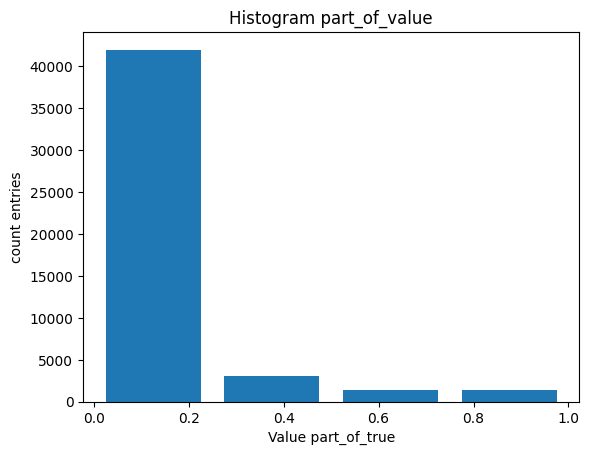

In [ ]:
pl = crowd_df['part_of_true'].plot(kind='hist', rwidth=0.8, bins=4, xlabel='Value part_of_true', ylabel='count entries', title='Histogram part_of_value')

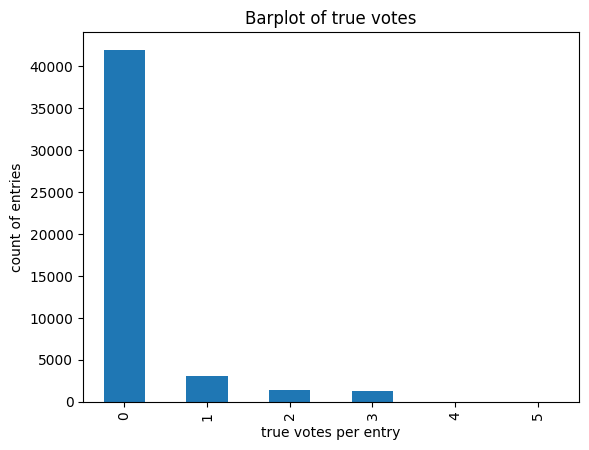

In [ ]:
pl = crowd_df.count_true.value_counts().reset_index(drop=True).plot(kind='bar', xlabel='true votes per entry', ylabel='count of entries', title='Barplot of true votes')

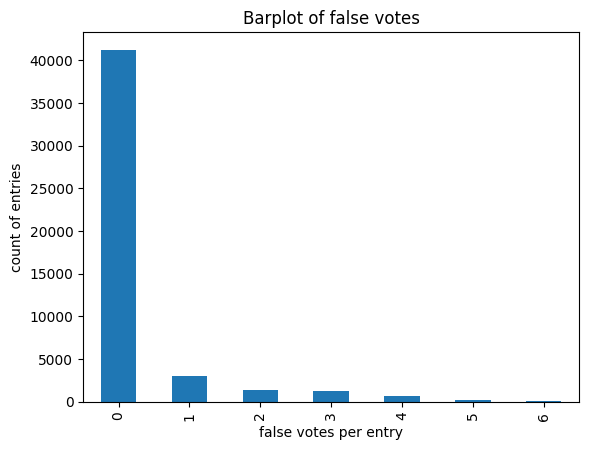

In [ ]:
pl = crowd_df.count_false.value_counts().reset_index(drop=True).plot(kind='bar', xlabel='false votes per entry', ylabel='count of entries', title='Barplot of false votes')

### Оценки экспертов

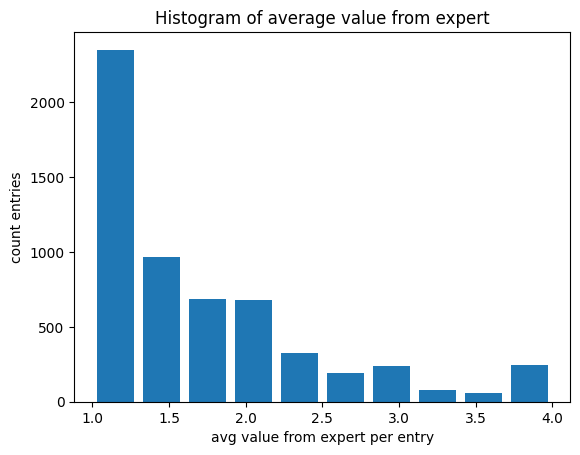

In [ ]:
pl = expert_df.agg(lambda x: np.average([x.exp_1, x.exp_2, x.exp_3]), axis=1).reset_index(drop=True).plot(kind='hist', rwidth=0.8, bins=10, xlabel='avg value from expert per entry', ylabel='count entries', title='Histogram of average value from expert')

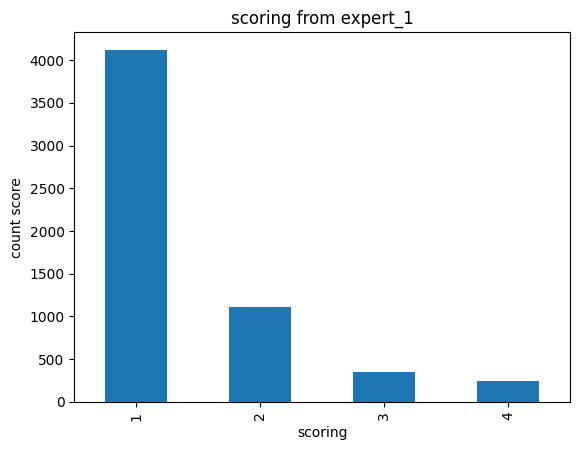

In [ ]:
pl = expert_df.exp_1.value_counts().plot(kind='bar', xlabel='scoring', ylabel='count score', title='scoring from expert_1')

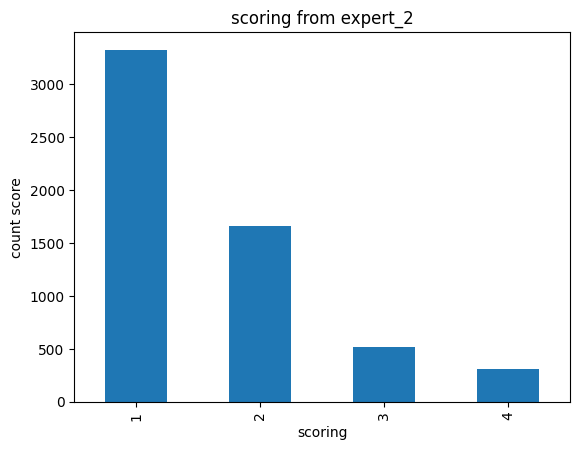

In [ ]:
pl = expert_df.exp_2.value_counts().plot(kind='bar', xlabel='scoring', ylabel='count score', title='scoring from expert_2')

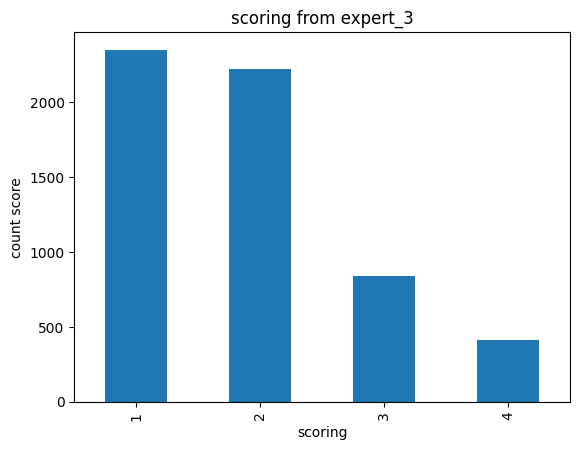

In [ ]:
pl = expert_df.exp_3.value_counts().plot(kind='bar', xlabel='scoring', ylabel='count score', title='scoring from expert_3')

**Промежуточный вывод:**

Выше был проведеён исследовательский анализ оценок экпертов и краудсорсинга. Анализ крадусорсинговых оценок показывает, что оценки достаточно несбалансированны, а доля высоких по схожести оценок по всему датасету мала. Оценки Экспертов показывают более выраженую бираность. Много в датасете оценок малой схожести. Т.е. данные не сбалансированы. Кроме того были показаны характерные особенности каждого экперта, а именно их различную лояльность/строгость в оценивании.

###  Создание целевого признака

Было принято решение использовать для созадния целевого признака оценки экпертов. Краудсорсинг показал себя не с лучшей стороны,  кроме того имеется экспертная разметка данных, что позволяет использовать более доверительные и компетентные данные. Для созадния целевого признака из оценок экпертов необходимо взять средне арифметическое для каждой записи и нормализовать данные для области от 0 до 1.

In [ ]:
# получение среденго значаения оценки для записи
expert_df['avg_score'] = expert_df.agg(lambda x: np.average([x.exp_1, x.exp_2, x.exp_3]), axis=1)

# вычисление среднего арифметического оценки
expert_df['target'] = round((expert_df['avg_score'] - 1)/3, 2)

In [ ]:
expert_df.sample(5)

image                     query_id  exp_1  exp_2  \
755   2089426086_7acc98a3a8.jpg  2877503811_4e311253ec.jpg#2      1      1   
1722  2549968784_39bfbe44f9.jpg  2384353160_f395e9a54b.jpg#2      1      1   
2435  2891617125_f939f604c7.jpg  3640422448_a0f42e4559.jpg#2      2      2   
5815   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2      1      1   
3643   326456451_effadbbe49.jpg  2932740428_b15384f389.jpg#2      1      1   

      exp_3  avg_score  target  
755       2       1.33    0.11  
1722      1       1.00    0.00  
2435      3       2.33    0.44  
5815      2       1.33    0.11  
3643      1       1.00    0.00

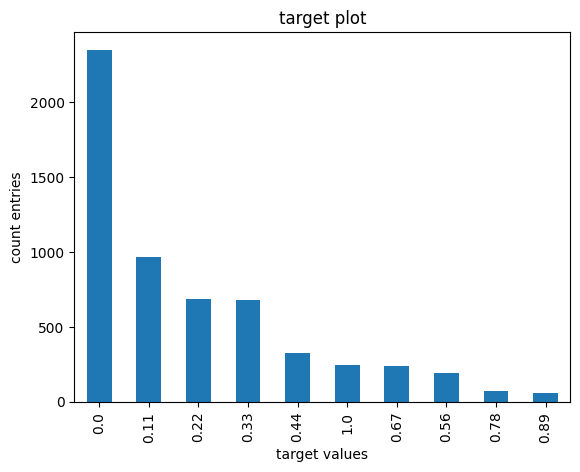

In [ ]:
pl = expert_df.target.value_counts().plot(kind='bar', xlabel='target values', ylabel='count entries', title='target plot')

### Создание рабочего датасета

In [ ]:
# выделение необходимых признаков в отдельный датафрейм
df = train_df.merge(expert_df[['image', 'query_id', 'target']], on=['image', 'query_id'])

In [ ]:
df.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  target  
0  A young child is wearing blue goggles and sitt...    0.00  
1  A young child is wearing blue goggles and sitt...    0.00  
2  A young child is wearing blue goggles and sitt...    0.22  
3  A young child is wearing blue goggles and sitt...    1.00  
4  A young child is wearing blue goggles and sitt...    0.00

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   target      5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


# Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
# from deepseek
child_related_words = [
    # Прямые обозначения детей и возрастные группы
    "baby", "infant", "newborn", "toddler", "child", "kid", "kiddo", "tot",
    "preschooler", "kindergartner", "schoolchild", "schoolkid", "pupil",
    "minor", "youngster", "juvenile", "teenybopper", "tween", "preteen",
    "teenager", "teen", "adolescent", "youth", "boy", "girl", "son", "daughter",
    "sibling", "grandchild", "nephew", "niece", "children",

    # Родство и опека (в контексте ребенка)
    "mommy", "mummy", "daddy", "parent", "mother", "father", "guardian",
    "caregiver", "babysitter", "nanny", "au pair",

    # Места, учреждения, мероприятия
    "nursery", "daycare", "preschool", "kindergarten", "playschool", "elementary",
    "primary", "grade", "playground", "sandbox", "playpen", "crib", "cradle",
    "stroller", "pram", "carseat", "highchair", "classroom", "recess", "fieldtrip",
    "birthday", "christening", "baptism",

    # Занятия, игрушки, предметы
    "toy", "doll", "teddy", "bear", "rattle", "blocks", "Lego", "Duplo", "cartoon",
    "animation", "pacifier", "soother", "dummy", "diaper", "nappy", "potty", "bib",
    "sippy", "bottle", "formula", "breastfeed", "lullaby", "storytime", "crayon",
    "coloring", "fingerpaint"
]

In [ ]:
# подготовка тектов запросов для лематизации, удаление лишних знаков
df['raw_query'] = df['query_text'].agg(lambda x: ' '.join(re.sub(r"[^a-zA-Z']", ' ', x).split()).lower()).astype('U')

In [ ]:
# лематизация текстов запросов
lemmatizer = WordNetLemmatizer()
df['lem_query_token'] = df['raw_query'].agg(lambda x: [lemmatizer.lemmatize(word=w, pos=t) for w, t in get_wordnet_mapping_pos(x)])

In [ ]:
# создание меток для запросов, которые не противоречат законам
df['is_good_query'] = df.lem_query_token.map(filter_warnings)

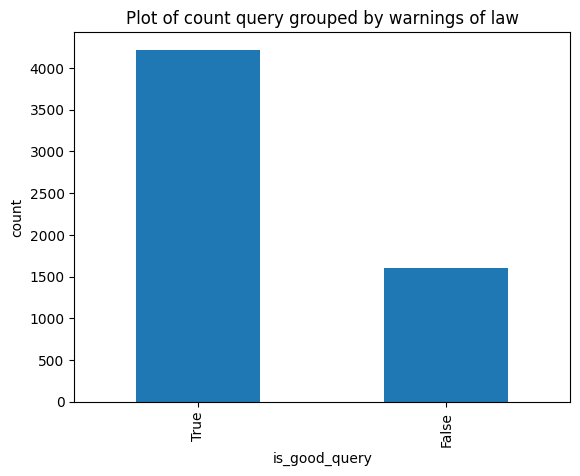

In [ ]:
pl = df.is_good_query.value_counts().plot(kind='bar', ylabel='count', title='Plot of count query grouped by warnings of law')

In [ ]:
# создание чистого датафрейма без незаконного контента
clean_df = df[df.is_good_query].reset_index()

In [ ]:
clean_df.shape

(4219, 8)

Очистка данных для законности датасета успешно пройдена. Было убрано из выборки около четверти изображений, которые не прошли проверку.

# Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
# создание генератора для загрузки изображений
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# создание объекта потока для загрузки изображений
data_image_flow = datagen.flow_from_dataframe(clean_df, x_col='image', directory=os.path.join(DATA_PATH, r'train_images'), class_mode='raw', y_col='target', seed=seed, shuffle=False)

Found 4219 validated image filenames.


In [ ]:
# создание модели для получения векторов изображений
backbone = ResNet50(include_top=False, input_shape=(256, 256, 3))
model = Sequential()
model.add(backbone)
# model.add(layers.Flatten())
model.add(layers.GlobalAveragePooling2D())

In [ ]:
# получение векторов изображений
prediction = model.predict(data_image_flow)

132/132 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step


In [ ]:
# проверка размерности вектора
prediction.shape

(4219, 2048)

In [ ]:
# создание датафрейма для веткоров и целевого признака
vect_df = pd.DataFrame()
vect_df['target'] = clean_df['target']
vect_df['img_vect'] = pd.Series(list(prediction))

In [ ]:
vect_df.head()

target                                           img_vect
0    0.11  [0.13310312, 0.051444396, 0.0, 1.8925395, 0.01...
1    0.22  [0.14719, 0.0073228627, 0.012283115, 2.1529717...
2    0.33  [0.06828938, 0.45791584, 0.10230033, 1.2434999...
3    0.22  [0.10133171, 0.8350836, 0.20641069, 0.5950195,...
4    0.11  [0.3357858, 0.5505409, 0.08698414, 0.5096968, ...

In [ ]:
vect_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4219 entries, 0 to 4218
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   target    4219 non-null   float64
 1   img_vect  4219 non-null   object 
dtypes: float64(1), object(1)
memory usage: 66.1+ KB


# Векторизация текстов


Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [ ]:
# загрузка модели BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#  получение векторов для тектов запросов. Если имеется файл с уже полученными векторами, заново вектроа не создаются.
if os.path.exists(r'texts_embeddings.pkl'):
    vect_df = pd.read_pickle('texts_embeddings.pkl')
else:
    vect_df['embedding'] = process_batch(clean_df['query_text'], batch_size=8)
    vect_df.to_pickle('texts_embeddings.pkl')

In [ ]:
vect_df.head()

target                                           img_vect  \
0    0.11  [0.13310312, 0.051444396, 0.0, 1.8925395, 0.01...   
1    0.22  [0.14719, 0.0073228627, 0.012283115, 2.1529717...   
2    0.33  [0.06828938, 0.45791584, 0.10230033, 1.2434999...   
3    0.22  [0.10133171, 0.8350836, 0.20641069, 0.5950195,...   
4    0.11  [0.3357858, 0.5505409, 0.08698414, 0.5096968, ...   

                                           embedding  
0  [0.22594528, -0.14776942, -0.41042575, 0.00985...  
1  [0.22594528, -0.14776942, -0.41042575, 0.00985...  
2  [0.22594528, -0.14776942, -0.41042575, 0.00985...  
3  [0.22594528, -0.14776942, -0.41042575, 0.00985...  
4  [0.22594528, -0.14776942, -0.41042575, 0.00985...

# Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [ ]:
train = pd.DataFrame()

In [ ]:
train['target'] = vect_df['target']

In [ ]:
# объединение векторов текста запроса и изображения
train['vector'] = vect_df.agg(lambda x: np.concatenate([x['embedding'], x['img_vect']], axis=0), axis=1)

In [ ]:
train.iloc[0]['vector'].shape

(2816,)

# Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

---

Для оценки качества модели выбарана метрика RMSE, так как она имеет ту же размерность, что и целевой признак.

In [ ]:
# умное разделение выборок
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=seed)
train_indices, test_indices = next(gss.split(X=train['vector'], y=train['target'], groups=clean_df['image']))
train_data, test_data = train.iloc[train_indices], train.iloc[test_indices]

In [ ]:
# деление на train и test
x_train = np.vstack(train_data['vector'].values)
y_train = train_data['target'].to_numpy()
x_valid = np.vstack(test_data['vector'].values)
y_valid = test_data['target'].to_numpy()

### Linear Regression

In [ ]:
# Линейная регрессия
optimizer = Adam(learning_rate=0.001)
linear_model = Sequential()
linear_model.add(layers.Dense(units=1, input_dim=x_train[0].shape[0]))
linear_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[RootMeanSquaredError()])

In [ ]:
linear_model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4919 - root_mean_squared_error: 0.6907 - val_loss: 0.3502 - val_root_mean_squared_error: 0.5918
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1872 - root_mean_squared_error: 0.4320 - val_loss: 0.2662 - val_root_mean_squared_error: 0.5160
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1118 - root_mean_squared_error: 0.3343 - val_loss: 0.2449 - val_root_mean_squared_error: 0.4948
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0874 - root_mean_squared_error: 0.2955 - val_loss: 0.2397 - val_root_mean_squared_error: 0.4896
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0745 - root_mean_squared_error: 0.2730 - val_loss: 0.2213 - val_root_mean_squared_error: 0.4704
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0796 - root_mean_squared_error: 0.2821 - val_loss: 0.2230 - val_root_mean_squared_error: 0.4722
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss:

### Полносвязная нейронная сеть

In [ ]:
# Полносвязная нейронка
optimizer = Adam(learning_rate=0.0001)
net_model = Sequential()
net_model.add(layers.Dense(units=512, input_dim=x_train[0].shape[0], activation='relu'))
net_model.add(layers.Dropout(0.4))
net_model.add(layers.Dense(128, activation='relu'))
net_model.add(layers.Dropout(0.4))
net_model.add(layers.Dense(16, activation='relu'))
net_model.add(layers.Dropout(0.4))
net_model.add(layers.Dense(4, activation='relu'))
net_model.add(layers.Dropout(0.4))
net_model.add(layers.Dense(1, activation='relu'))

net_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[RootMeanSquaredError()])

In [ ]:
%%time
net_model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.1589 - root_mean_squared_error: 0.3965 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3591
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.1333 - root_mean_squared_error: 0.3650 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3591
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.1389 - root_mean_squared_error: 0.3726 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3591
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.1334 - root_mean_squared_error: 0.3651 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3591
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.1228 - root_mean_squared_error: 0.3498 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3591
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.1358 - root_mean_squared_error: 0.3684 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3591
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms

**Промежуточные выводы**

В результате проведения обучения различных моделей можно сделать вывод, что полносвязная нейронная сеть с несколькими скрытыми слоями, для обучения которой используется несколько эпох, намного лучше обычной линейной регрессии. Нейронная сеть на тестовых даннных имеет значение метрики (rmse) не выше 0.3.

# Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
# создание генератора для загрузки изображений
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
data_image_flow = datagen.flow_from_dataframe(test_img, x_col='image', directory=os.path.join(DATA_PATH, r'test_images'), class_mode=None, y_col=None, seed=seed, shuffle=False)

Found 100 validated image filenames.


In [ ]:
# создание модели для получения векторов изображений
backbone = ResNet50(include_top=False, input_shape=(256, 256, 3))
model = Sequential()
model.add(backbone)
# model.add(layers.Flatten())
model.add(layers.GlobalAveragePooling2D())

In [ ]:
# получение векторов изображений
prediction = model.predict(data_image_flow)

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [ ]:
# создание датафрейма с фалйами изображений и их векторами.
test_img_df = pd.DataFrame()
test_img_df['img'] = test_img['image']
test_img_df['img_vect'] = pd.Series(list(prediction))

In [ ]:
# взятие случайных 10 текстовых запросов из выборки
test_sample = test_q.sample(10).reset_index()

In [ ]:
# создание датафрейма для 10 выбранных запрососв
test_query_df = pd.DataFrame()
test_query_df['query_text'] = test_sample.query_text
test_query_df['relevant_img'] = test_sample.image

In [ ]:
# получение векторов для тектсовых зарпосов
test_query_df['query_vector'] = process_batch(test_query_df.query_text, batch_size=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.51it/s]


Полученный запрос:
 Two people are sitting on a wooden structure near a tree while conversing .

Релевантное изображение


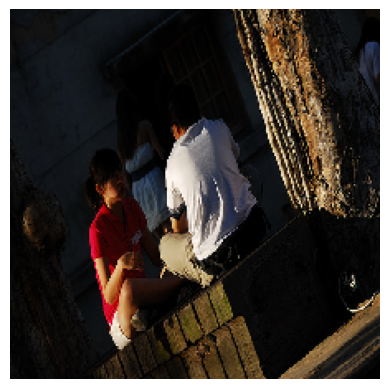

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Самая высокая оценка совместимости по имеющимся изображениям: 0.14503513276576996
Три лучших изображения по запросу


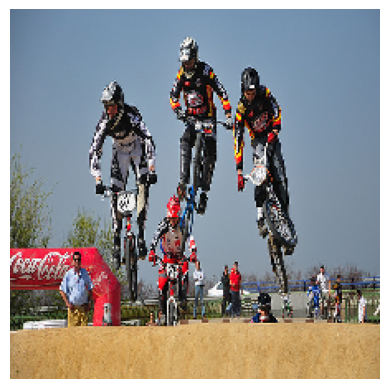

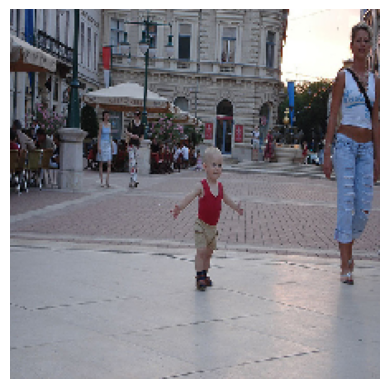

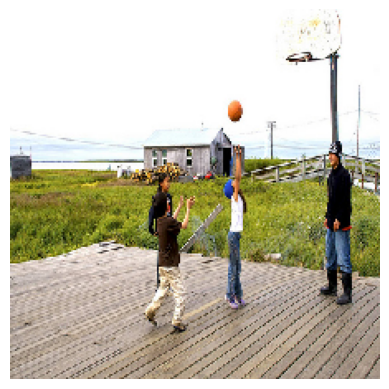

In [ ]:
submit_query(test_query_df.iloc[0])

In [ ]:
submit_query(test_query_df.iloc[1])

Полученный запрос:
 A little girl with a purple fuzzy hat is riding a tricycle outside .

THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS


In [ ]:
submit_query(test_query_df.iloc[2])

Полученный запрос:
 a boy flings sand at a girl .

THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS


In [ ]:
submit_query(test_query_df.iloc[3])

Полученный запрос:
 Two women , one with a head bandanna , are standing next to each other while one holds a bottle .

THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS


Полученный запрос:
 The man is standing next to a dog , while the dog jumps in the air .

Релевантное изображение


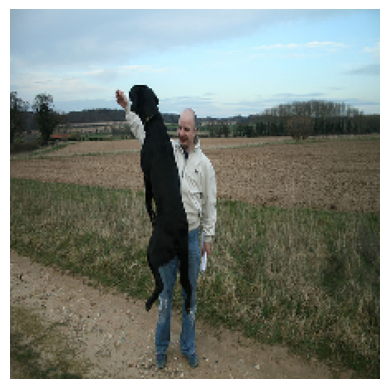

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Самая высокая оценка совместимости по имеющимся изображениям: 0.14503513276576996
Три лучших изображения по запросу


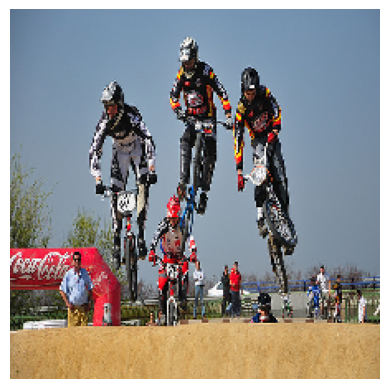

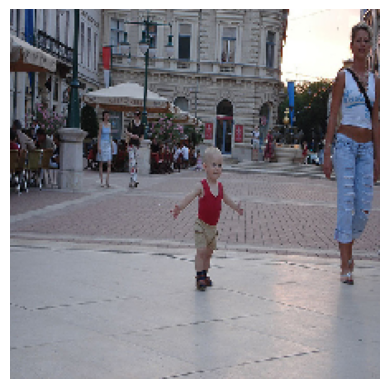

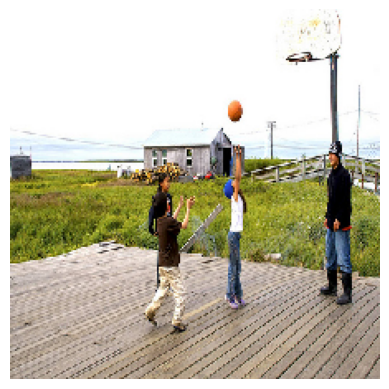

In [ ]:
submit_query(test_query_df.iloc[4])

In [ ]:
submit_query(test_query_df.iloc[5])

Полученный запрос:
 A girl in a pool wearing goggles and surrounded by other children

THIS IMAGE IS UNAVAILABLE IN YOUR COUNTRY IN COMPLIANCE WITH LOCAL LAWS


Полученный запрос:
 A man wearing a vest and pants walks across stage at a concert .

Релевантное изображение


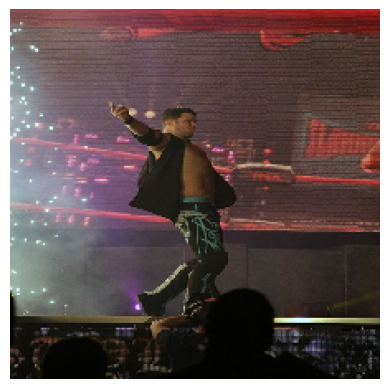

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Самая высокая оценка совместимости по имеющимся изображениям: 0.14503513276576996
Три лучших изображения по запросу


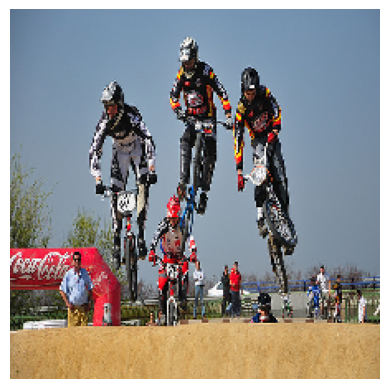

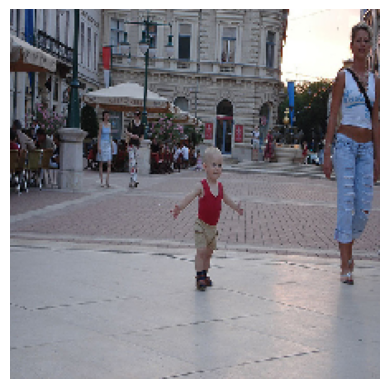

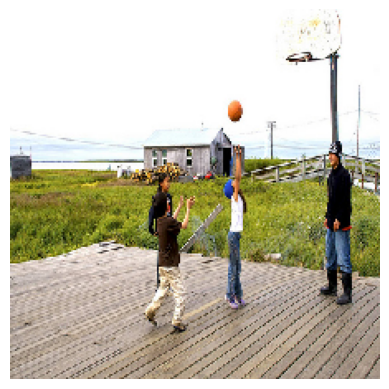

In [ ]:
submit_query(test_query_df.iloc[6])

Полученный запрос:
 The dog is sitting on the side of the hill .

Релевантное изображение


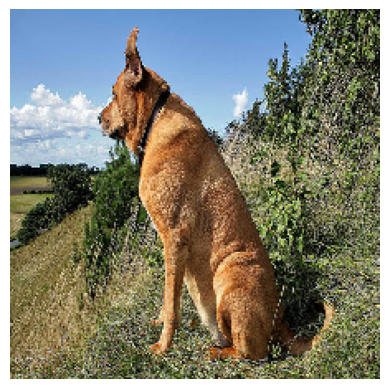

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Самая высокая оценка совместимости по имеющимся изображениям: 0.14503513276576996
Три лучших изображения по запросу


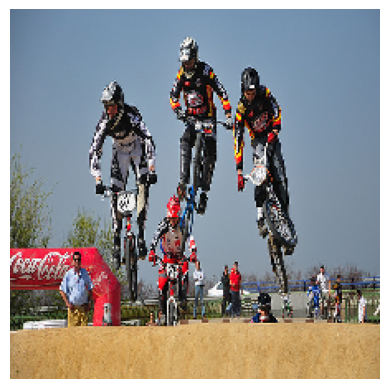

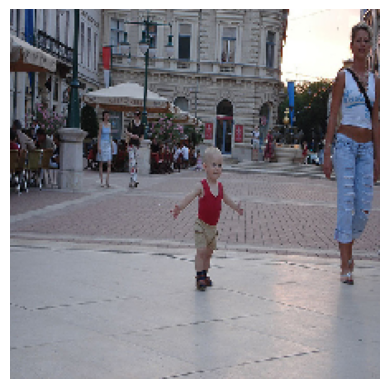

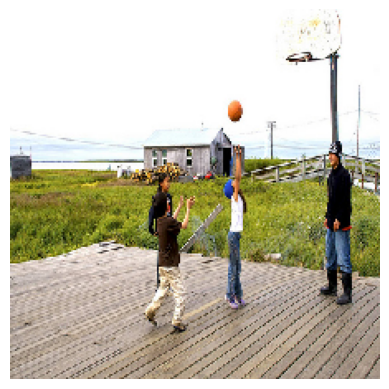

In [ ]:
submit_query(test_query_df.iloc[7])

Полученный запрос:
 The middle eastern woman wearing the pink headscarf is walking beside a woman in a purple headscarf .

Релевантное изображение


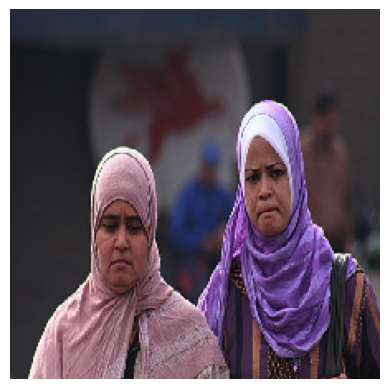

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Самая высокая оценка совместимости по имеющимся изображениям: 0.14503513276576996
Три лучших изображения по запросу


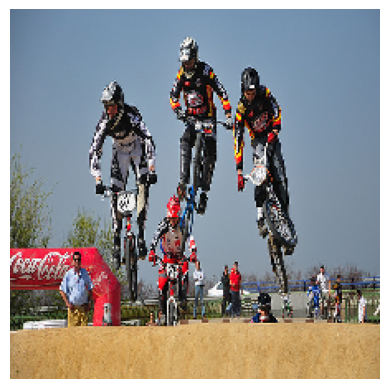

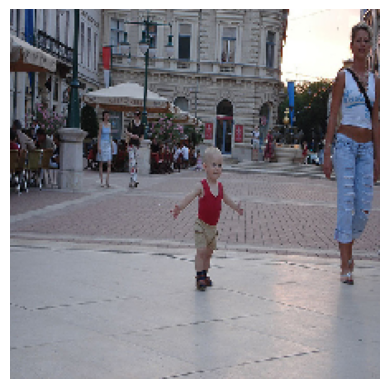

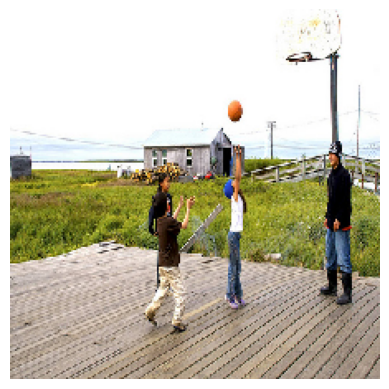

In [ ]:
submit_query(test_query_df.iloc[8])

Полученный запрос:
 A man with something orange on his helmet riding a bike in a busy setting .

Релевантное изображение


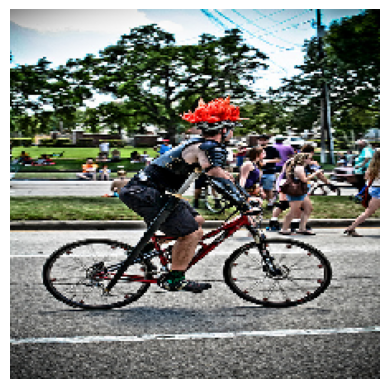

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Самая высокая оценка совместимости по имеющимся изображениям: 0.14503513276576996
Три лучших изображения по запросу


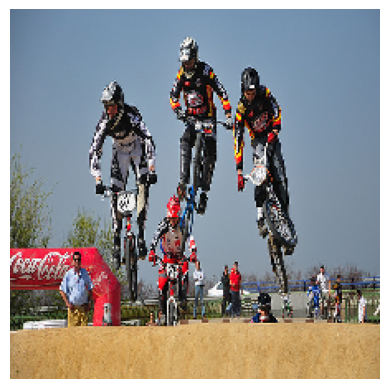

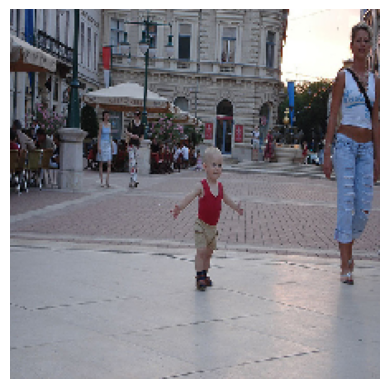

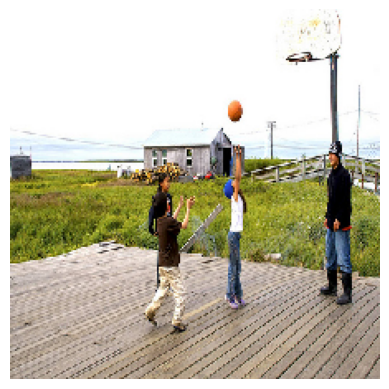

In [ ]:
submit_query(test_query_df.iloc[9])

**Выводы по тестированию MVP**

Визуально модель не достигла необходимой цели. Очевидно, что из выборки тестовых изображений модель отобрала фаворитов и практически не обращала внимание на запрос. Это может навести на мысль, что принцип подготовки данных для обучения модели неверен.

Кроме того, ограничения законов 18+ изображений не работают, что очевдно, потому что модели об этом не было известно, а очищались только тренировочные данные,- тестовая выборка не проверялась на соответсвие законам.

Также по выводу целевой переменной видно, что модель не достигала на выборке больших значений соответсвия запроса и изображения.

# Выводы

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска